# DRCNet

In [1]:
import logging
import os
import torch
from torch.utils.data import DataLoader
from drcnet.fit import fit_model
from drcnet.model import DenoiserNet
from utils import setup_logging
from utils.data import DBrainDataLoader, StanfordDataLoader
from utils.metrics import visualize_single_volume
from utils.utils import load_config

train = False
dataset = "dbrain"
# Setup logging
log_file = setup_logging(log_level=logging.INFO)
logging.info(f"Starting training with dataset: {dataset}")

# Get the directory where this script is located
script_dir = "/home/paco/TechJourney/TechJourney/DWMRI/src/drcnet"
config_path = os.path.join(script_dir, "config.yaml")

logging.info(f"Loading config from: {config_path}")

settings = load_config(config_path)
logging.info("Configuration loaded successfully")

if dataset == "dbrain":
    logging.info("Using DBrain dataset configuration")
    settings = settings.dbrain
    data_loader = DBrainDataLoader(
        nii_path=settings.data.nii_path,
        bvecs_path=settings.data.bvecs_path,
        bvalue=settings.data.bvalue,
        noise_sigma=settings.data.noise_sigma,
    )
original_data, noisy_data = data_loader.load_data()
take_volumes = settings.data.num_b0s + settings.data.num_volumes
logging.info(
    f"Taking volumes from {settings.data.num_b0s} to {take_volumes}"
)
noisy_data = noisy_data[
    : settings.data.take_x,
    : settings.data.take_y,
    : settings.data.take_z,
    settings.data.num_b0s : take_volumes,
]
original_data = original_data[
        : settings.data.take_x,
        : settings.data.take_y,
        : settings.data.take_z,
        settings.data.num_b0s : take_volumes,
    ]


/home/paco/vqvae/env-torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-21 13:34:32,401 - root - INFO - Logging configured - level: INFO, file: logs/training_20250921_133432.log
2025-09-21 13:34:32,403 - root - INFO - Starting training with dataset: dbrain
2025-09-21 13:34:32,403 - root - INFO - Loading config from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-09-21 13:34:32,404 - root - INFO - Loading configuration from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-09-21 13:34:32,411 - root - INFO - Configuration file loaded successfully
2025-09-21 13:34:32,413 - root - INFO - Configuration converted to Munch object
2025-09-21 13:34:32,413 - root - INFO - Configuration loaded successfully
2025-09-21 13:34:32,414 - root - INFO - Using DBrain dat

(96, 10, 128, 128)


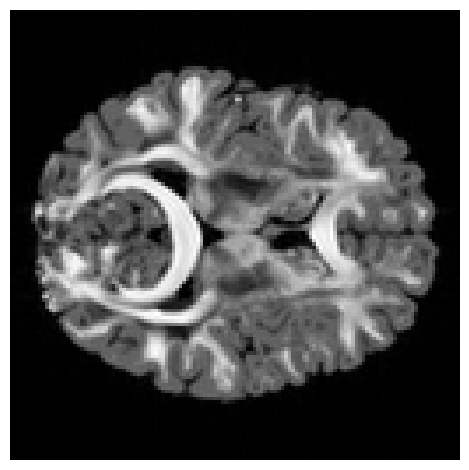

In [2]:
import numpy as np

visualize_single_volume(
                np.transpose(original_data, (2,3,0,1)),
            )

(96, 10, 128, 128)


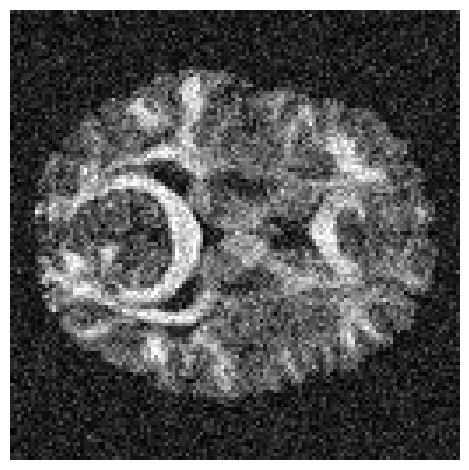

In [3]:
import numpy as np

visualize_single_volume(
                np.transpose(noisy_data, (2,3,0,1)),
            )

In [4]:
# setting checkpoint dir taking into account run/model parameters
checkpoint_dir = os.path.join(
    settings.train.checkpoint_dir,
    f"bvalue_{settings.data.bvalue}",
    f"num_volumes_{settings.data.num_volumes}",
    f"noise_sigma_{settings.data.noise_sigma}",
    f"learning_rate_{settings.train.learning_rate}",
)
os.makedirs(checkpoint_dir, exist_ok=True)


In [5]:
import logging
import os

import numpy as np
import torch
from drcnet.data import ReconstructionDataSet, TrainingDataSet
from drcnet.fit import fit_model
from drcnet.model import DenoiserNet
from drcnet.reconstruction import reconstruct_dwis
from torch.utils.data import DataLoader
from utils import setup_logging
from utils.checkpoint import load_checkpoint
from utils.data import DBrainDataLoader, StanfordDataLoader
from utils.metrics import (
    compare_volumes,
    compute_metrics,
    save_metrics,
    visualize_single_volume,
)
from utils.utils import load_config

logging.info("Reconstructing DWIs...")
best_loss_checkpoint = os.path.join(
    checkpoint_dir, "best_loss_checkpoint.pth"
)
reconstruct_model = DenoiserNet(
    input_channels=settings.model.in_channel,
    output_channels=settings.model.out_channel,
    groups=settings.model.groups,
    dense_convs=settings.model.dense_convs,
    residual=settings.model.residual,
    base_filters=settings.model.base_filters,
    output_shape=(
        settings.model.out_channel,
        settings.data.take_x,
        settings.data.take_y,
        settings.data.take_z,
    ),
    device=settings.train.device,
)
reconstruct_model, _, _, _, _ = load_checkpoint(
    model=reconstruct_model,
    optimizer=None,
    filename=best_loss_checkpoint,
    device=settings.reconstruct.device,
)
reconstruct_set = ReconstructionDataSet(noisy_data)
reconstruct_loader = DataLoader(
    reconstruct_set, batch_size=1, shuffle=False
)
reconstructed_dwis = reconstruct_dwis(
    model=reconstruct_model,
    data_loader=reconstruct_loader,
    device=settings.reconstruct.device,
)
reconstructed_dwis = np.transpose(reconstructed_dwis, (1, 2, 3, 0))
logging.info(f"Reconstructed DWIs shape: {reconstructed_dwis.shape}")
logging.info(
    f"Reconstructed DWIs min: {reconstructed_dwis.min():.4f}, "
    f"max: {reconstructed_dwis.max():.4f}, "
    f"mean: {reconstructed_dwis.mean():.4f}"
)


2025-09-21 13:34:45,302 - root - INFO - Reconstructing DWIs...
2025-09-21 13:34:45,303 - root - INFO - Initializing DenoiserNet: input_channels=9, output_channels=1, groups=4, dense_convs=3, residual=True, base_filters=32
2025-09-21 13:34:45,324 - root - INFO - Initializing GatedBlock: x_channels=32, h_channels=32, dense_convs=3, groups=4
2025-09-21 13:34:45,325 - root - INFO - Initializing DenoisingBlock: in_channels=64, inner_channels=32, out_channels=32, inner_convolutions=3, residual=False
2025-09-21 13:34:45,327 - root - INFO - Initializing FactorizedBlock: in_channels=96, out_channels=32, groups=4
2025-09-21 13:34:45,328 - root - INFO - Initializing FactorizedBlock: in_channels=128, out_channels=32, groups=4
2025-09-21 13:34:45,330 - root - INFO - Initializing FactorizedBlock: in_channels=160, out_channels=32, groups=4
2025-09-21 13:34:45,333 - root - INFO - DenoiserNet model created - Total parameters: 71,978, Trainable parameters: 71,978
2025-09-21 13:34:45,334 - root - INFO - 

In [6]:
reconstructed_dwis.shape

(128, 128, 96, 10)

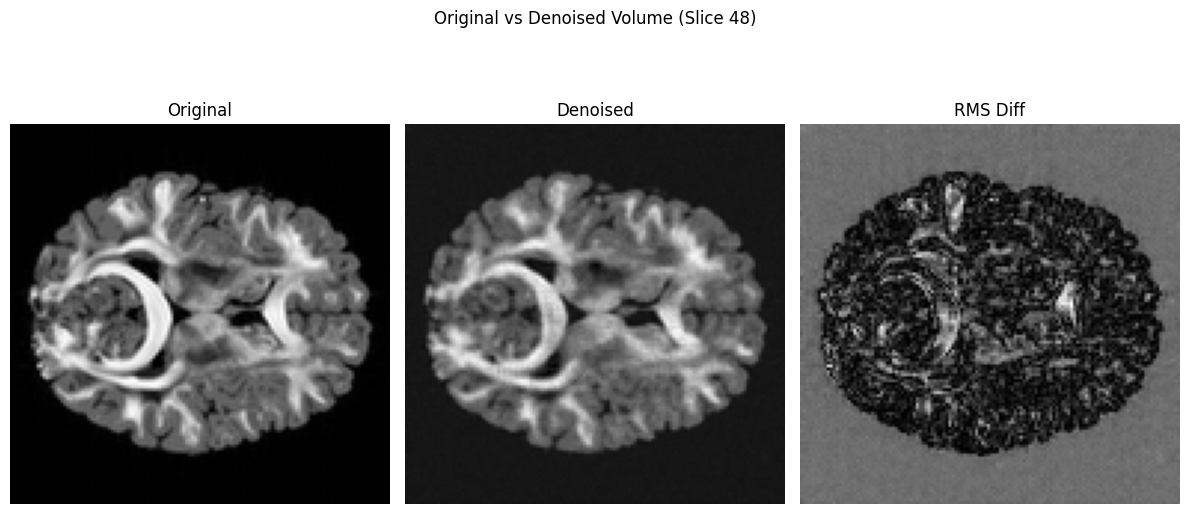

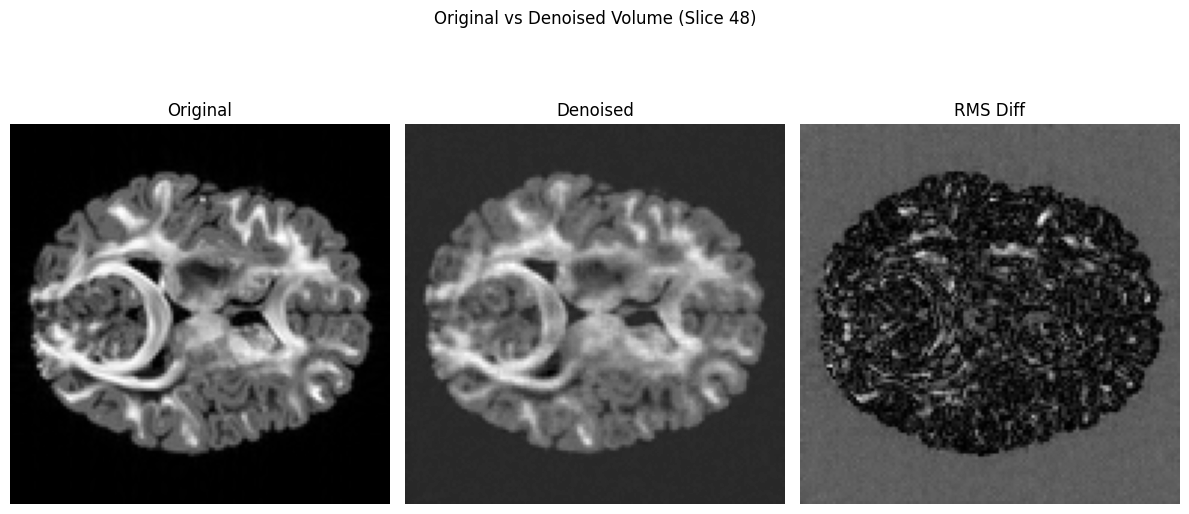

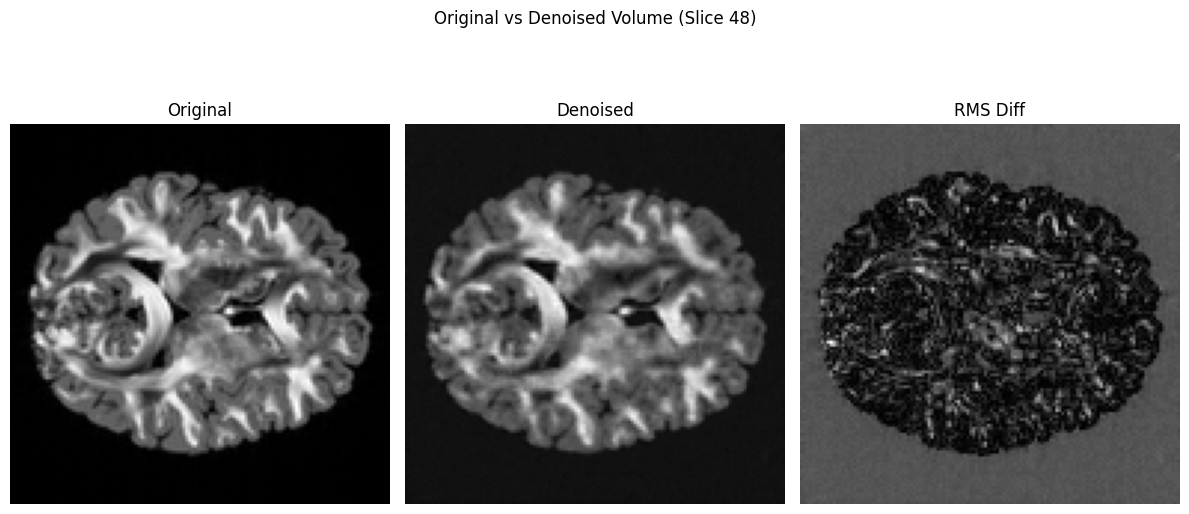

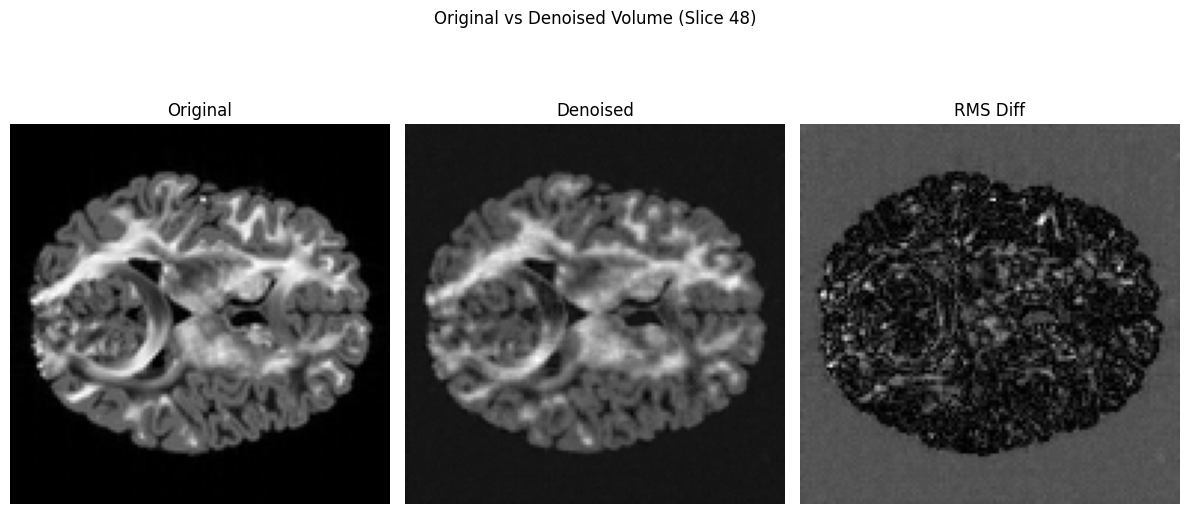

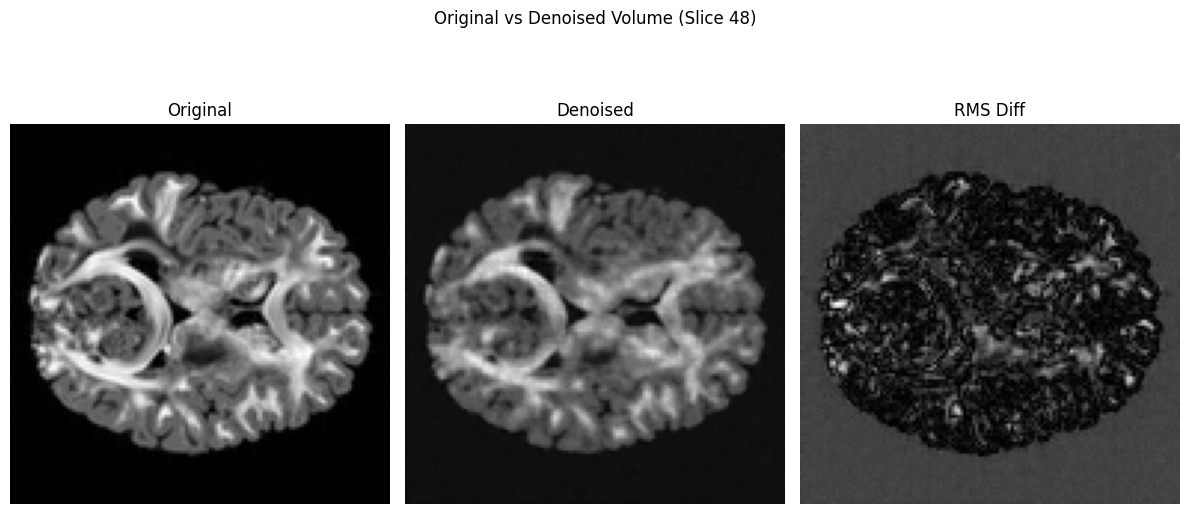

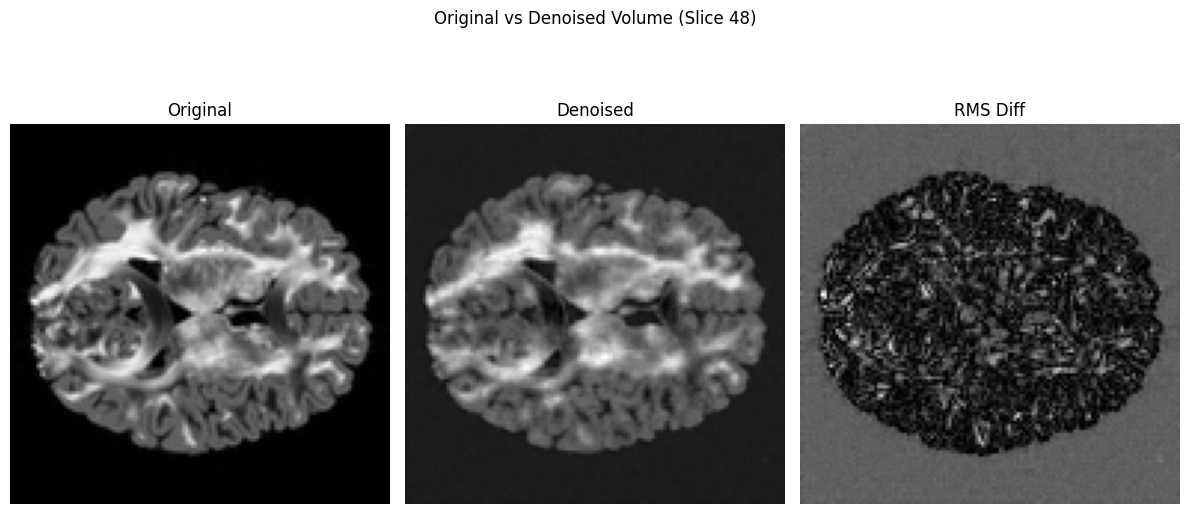

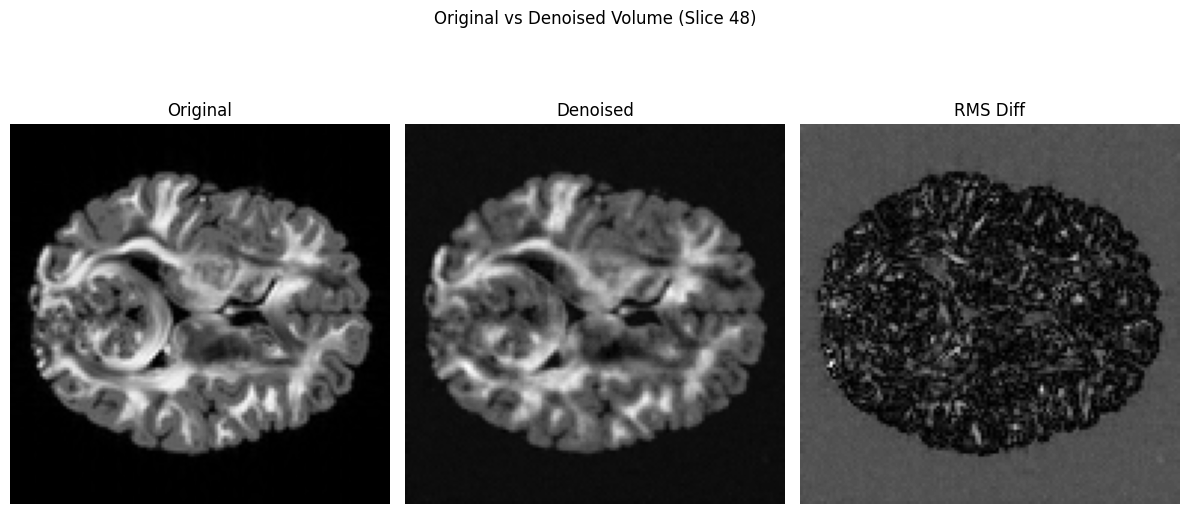

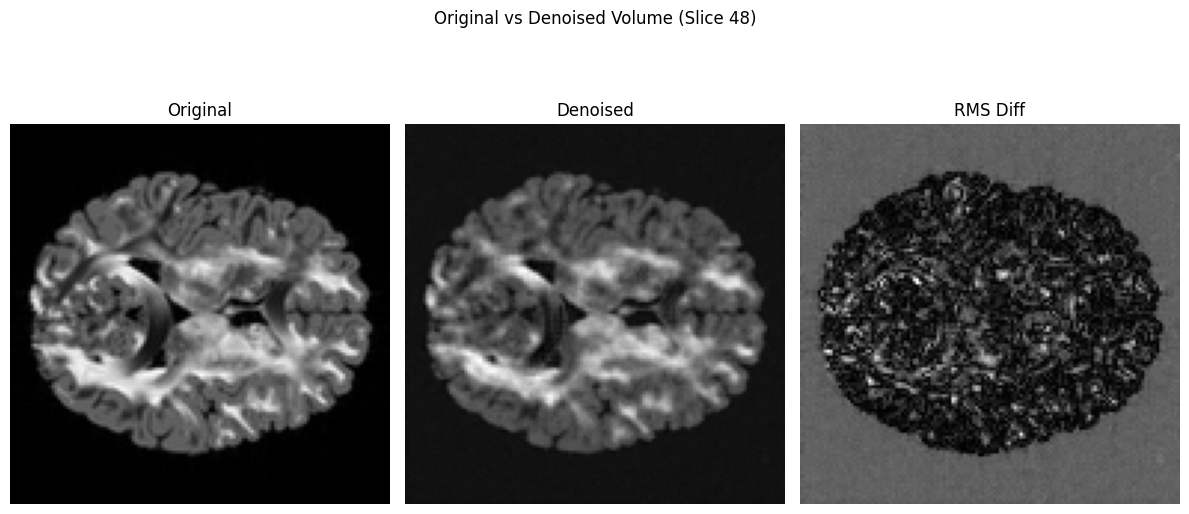

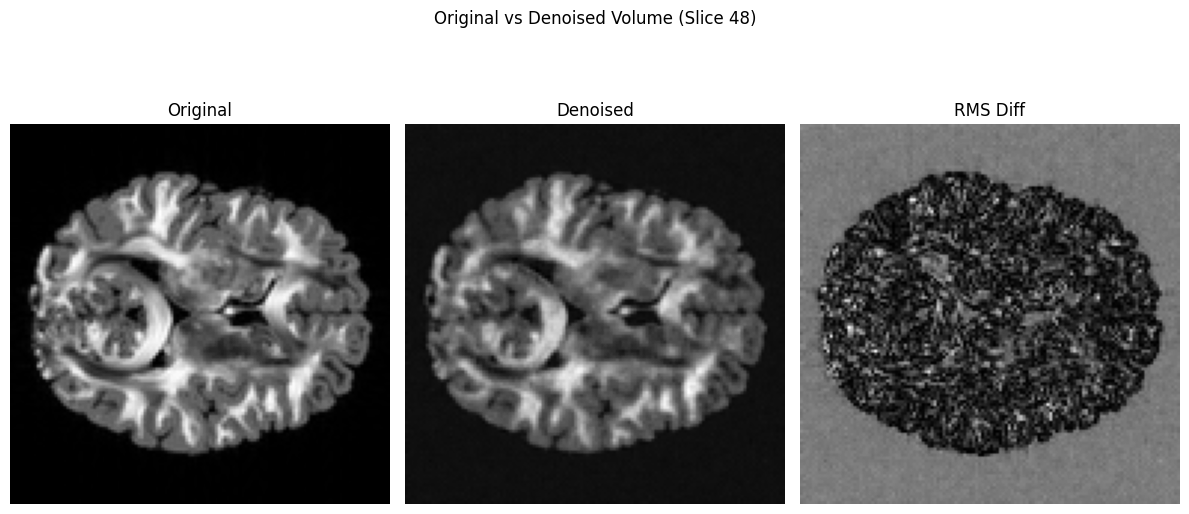

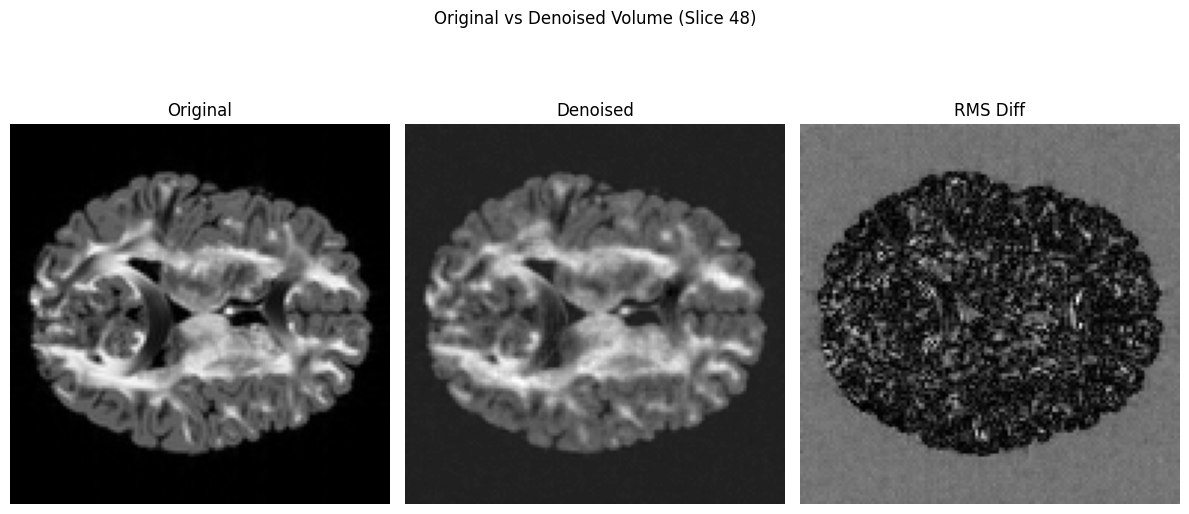

In [19]:
for i in range(10):
    compare_volumes(
                # volumes in b,z,x,y
                np.transpose(original_data, (2,3,0,1)),
                np.transpose(reconstructed_dwis, (2,3,0,1)),
                volume_idx=i,
    slice_idx=48,
            )

In [8]:
original_data.shape, reconstructed_dwis.shape, noisy_data.shape

((128, 128, 96, 10), (128, 128, 96, 10), (128, 128, 96, 10))

In [9]:
compute_metrics(
            original_data,
            noisy_data,
        )

{'psnr': 17.8278637607119,
 'ssim': 0.3141888380050659,
 'mse': 0.016489733010530472}

In [10]:
compute_metrics(
            original_data,
            reconstructed_dwis,
        )

{'psnr': 19.479077743893075,
 'ssim': 0.3864728510379791,
 'mse': 0.01127436850219965}

# MDS2S

In [1]:
import logging
import os
import torch
from torch.utils.data import DataLoader
from drcnet.fit import fit_model
from drcnet.model import DenoiserNet
from utils import setup_logging
from utils.data import DBrainDataLoader, StanfordDataLoader
from utils.metrics import visualize_single_volume
from utils.utils import load_config
import numpy as np

train = False
dataset = "dbrain"
# Setup logging
log_file = setup_logging(log_level=logging.INFO)
logging.info(f"Starting training with dataset: {dataset}")

# Get the directory where this script is located
script_dir = "/home/paco/TechJourney/TechJourney/DWMRI/src/mds2s"
config_path = os.path.join(script_dir, "config.yaml")

logging.info(f"Loading config from: {config_path}")

settings = load_config(config_path)
logging.info("Configuration loaded successfully")

if dataset == "dbrain":
    logging.info("Using DBrain dataset configuration")
    settings = settings.dbrain
    data_loader = DBrainDataLoader(
        nii_path=settings.data.nii_path,
        bvecs_path=settings.data.bvecs_path,
        bvalue=settings.data.bvalue,
        noise_sigma=settings.data.noise_sigma,
    )
original_data, noisy_data = data_loader.load_data()
take_volumes = settings.data.num_b0s + settings.data.num_volumes
logging.info(
    f"Taking volumes from {settings.data.num_b0s} to {take_volumes}"
)
noisy_data = np.transpose(
        noisy_data[..., settings.data.num_b0s : take_volumes],
        (2, 3, 0, 1),
    )


/home/paco/vqvae/env-torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-25 21:38:29,231 - root - INFO - Logging configured - level: INFO, file: logs/training_20250825_213829.log
2025-08-25 21:38:29,232 - root - INFO - Starting training with dataset: dbrain
2025-08-25 21:38:29,232 - root - INFO - Loading config from: /home/paco/TechJourney/TechJourney/DWMRI/src/mds2s/config.yaml
2025-08-25 21:38:29,233 - root - INFO - Loading configuration from: /home/paco/TechJourney/TechJourney/DWMRI/src/mds2s/config.yaml
2025-08-25 21:38:29,238 - root - INFO - Configuration file loaded successfully
2025-08-25 21:38:29,239 - root - INFO - Configuration converted to Munch object
2025-08-25 21:38:29,240 - root - INFO - Configuration loaded successfully
2025-08-25 21:38:29,241 - root - INFO - Using DBrain datas

(97, 10, 128, 128)


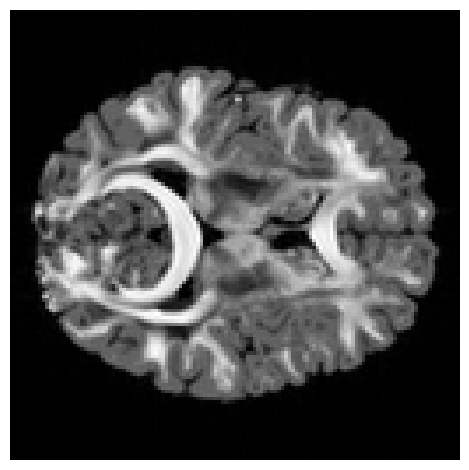

In [8]:
import numpy as np

visualize_single_volume(
                np.transpose(original_data[...,6:16], (2,3,0,1)),
    
            )

(97, 10, 128, 128)


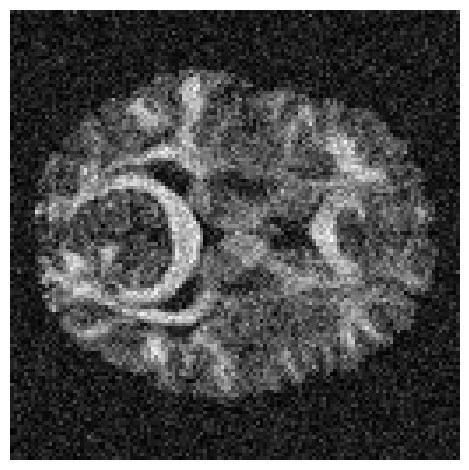

In [3]:
import numpy as np

visualize_single_volume(
                noisy_data,
            )

In [4]:
# setting checkpoint dir taking into account run/model parameters
checkpoint_dir = os.path.join(
    settings.train.checkpoint_dir,
    f"bvalue_{settings.data.bvalue}",
    f"num_volumes_{settings.data.num_volumes}",
    f"noise_sigma_{settings.data.noise_sigma}",
    f"learning_rate_{settings.train.learning_rate}",
)
os.makedirs(checkpoint_dir, exist_ok=True)


In [9]:
import logging
import os

import numpy as np
import torch
from mds2s.fit import fit_model
from mds2s.model import Self2self
from mds2s.reconstruction import reconstruct_dwis
from torch.utils.data import DataLoader
from utils import setup_logging
from utils.checkpoint import load_checkpoint
from torch.utils.data import DataLoader, TensorDataset
from utils.data import DBrainDataLoader, StanfordDataLoader
from utils.metrics import (
    compare_volumes,
    compute_metrics,
    save_metrics,
    visualize_single_volume,
)
from utils.utils import load_config

x_train = torch.from_numpy(noisy_data).type(torch.float)
logging.info(
        f"Converted to torch tensor: {x_train.shape}, dtype: {x_train.dtype}"
    )

train_set = TensorDataset(x_train)

logging.info("Reconstructing DWIs...")
best_loss_checkpoint = os.path.join(
    checkpoint_dir, "best_loss_checkpoint.pth"
)
reconstruct_model = Self2self(
            in_channel=settings.model.in_channel,
            out_channel=settings.model.out_channel,
            p=settings.train.dropout_p,
        )
optimizer = torch.optim.Adam(
        reconstruct_model.parameters(), lr=settings.train.learning_rate
    )
reconstruct_model, _, _, _, _ = load_checkpoint(
            model=reconstruct_model,
            optimizer=optimizer,
            filename=best_loss_checkpoint,
            device=settings.reconstruct.device,
        )
reconstruct_loader = DataLoader(train_set, batch_size=1, shuffle=False)
reconstructed_dwis = reconstruct_dwis(
            model=reconstruct_model,
            data_loader=reconstruct_loader,
            device=settings.reconstruct.device,
            data_shape=x_train.shape,
            mask_p=settings.reconstruct.mask_p,
            n_preds=settings.reconstruct.n_preds,
        )
logging.info(f"Reconstructed DWIs shape: {reconstructed_dwis.shape}")
logging.info(
            f"Reconstructed DWIs min: {reconstructed_dwis.min():.4f}, "
            f"max: {reconstructed_dwis.max():.4f}, "
            f"mean: {reconstructed_dwis.mean():.4f}"
        )
logging.info(f"Reconstructed DWIs dtype: {reconstructed_dwis.dtype}")

2025-08-25 21:49:12,405 - root - INFO - Converted to torch tensor: torch.Size([97, 10, 128, 128]), dtype: torch.float32
2025-08-25 21:49:12,407 - root - INFO - Reconstructing DWIs...
2025-08-25 21:49:12,408 - root - INFO - Self2self model initializing - in_channel: 10, out_channel: 10, dropout_p: 0.3
2025-08-25 21:49:12,408 - root - INFO - Model architecture - n_blks: 10, channel_size: 64
2025-08-25 21:49:12,426 - root - INFO - Self2self model created - Total parameters: 752,824, Trainable parameters: 752,824
2025-08-25 21:49:12,428 - root - INFO - Attempting to load checkpoint from: mds2s/checkpoints/dbrain/bvalue_2500/num_volumes_10/noise_sigma_0.1/learning_rate_0.0001/best_loss_checkpoint.pth
2025-08-25 21:49:12,547 - root - INFO - Checkpoint loaded successfully: mds2s/checkpoints/dbrain/bvalue_2500/num_volumes_10/noise_sigma_0.1/learning_rate_0.0001/best_loss_checkpoint.pth
2025-08-25 21:49:12,548 - root - INFO - Checkpoint details - epoch: 1959, loss: 0.003987, best_loss: 0.003987

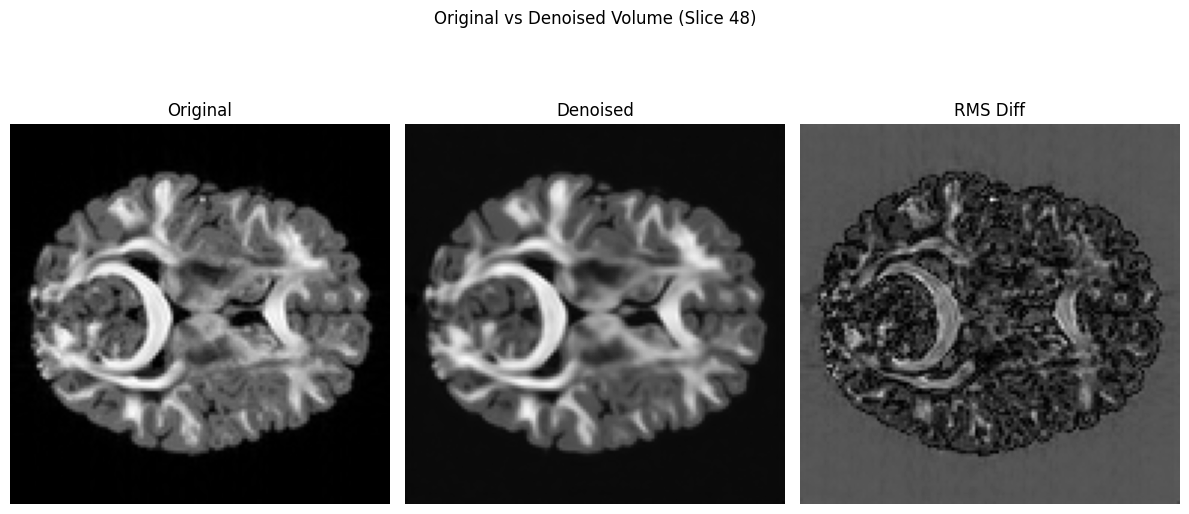

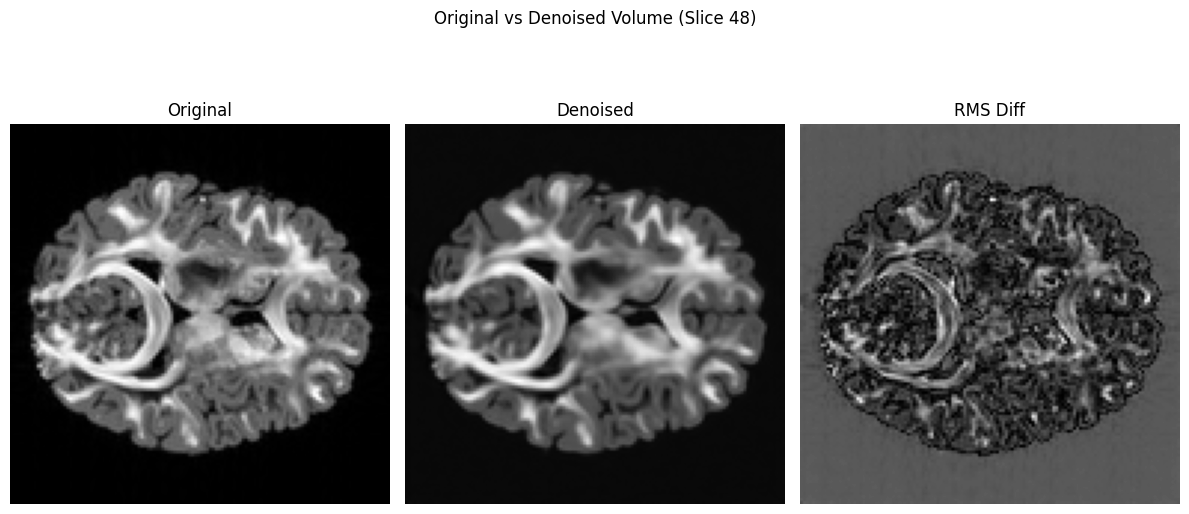

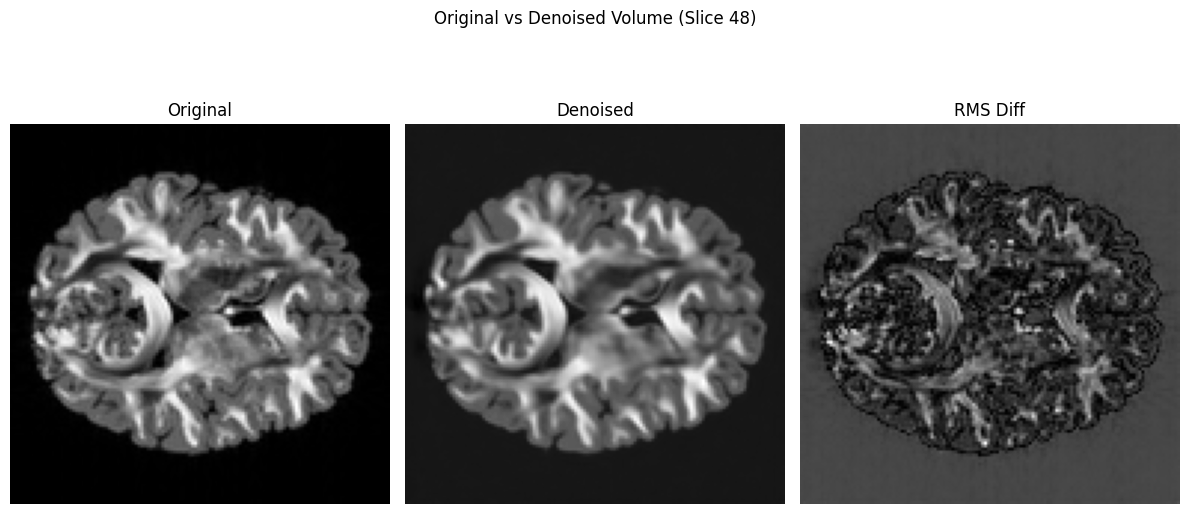

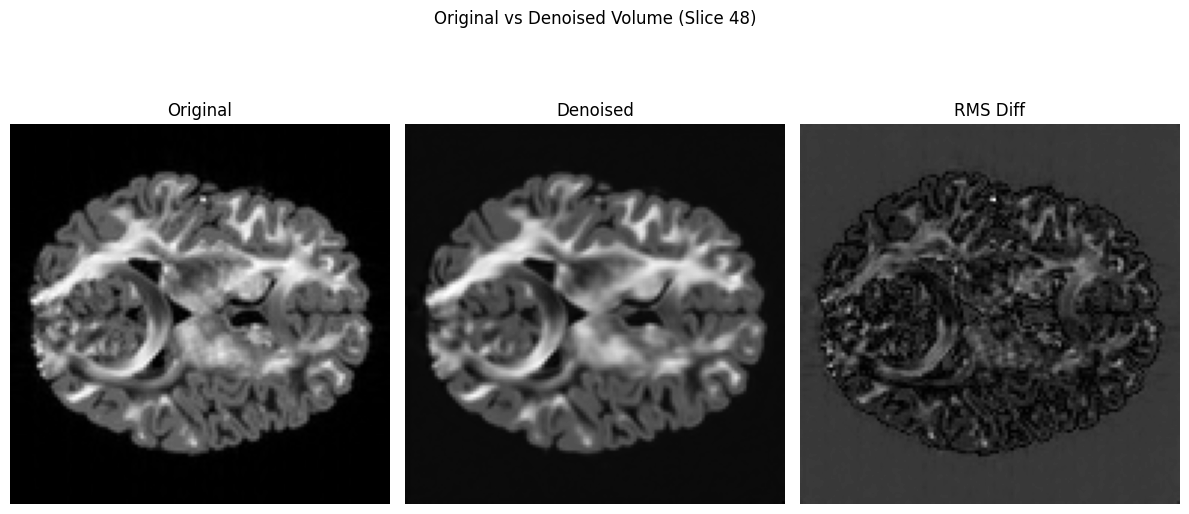

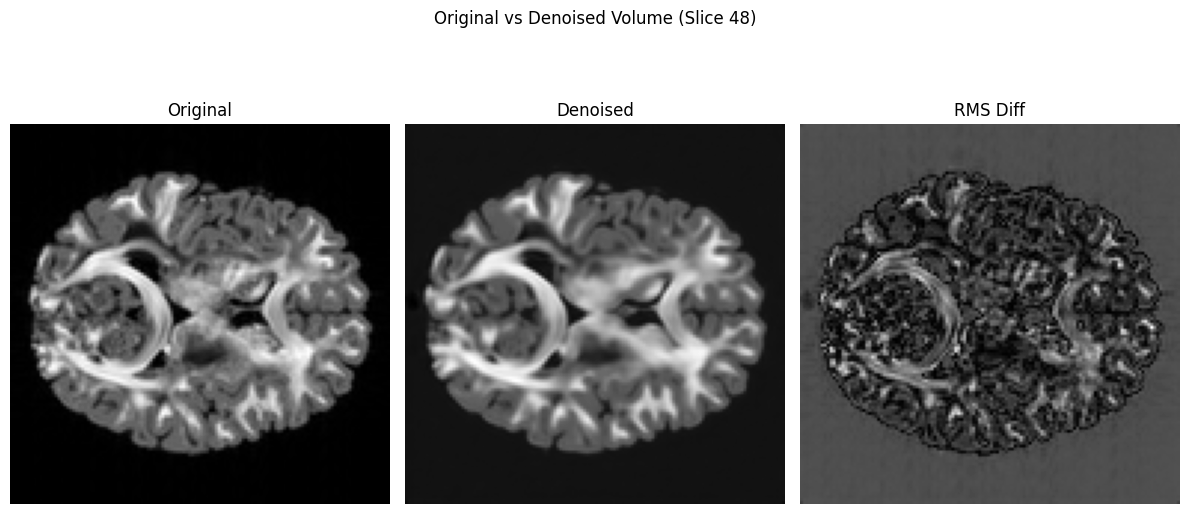

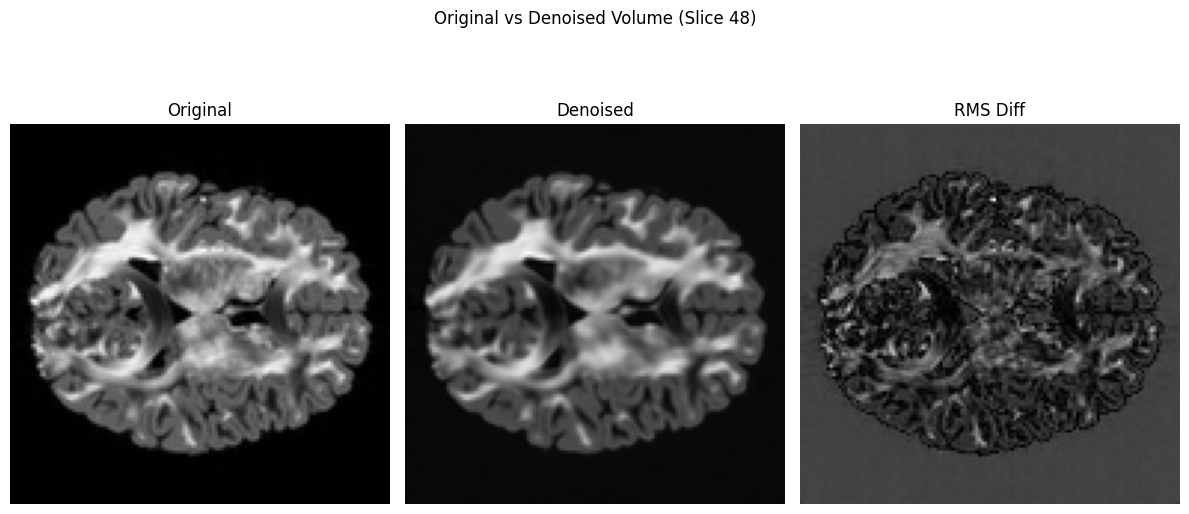

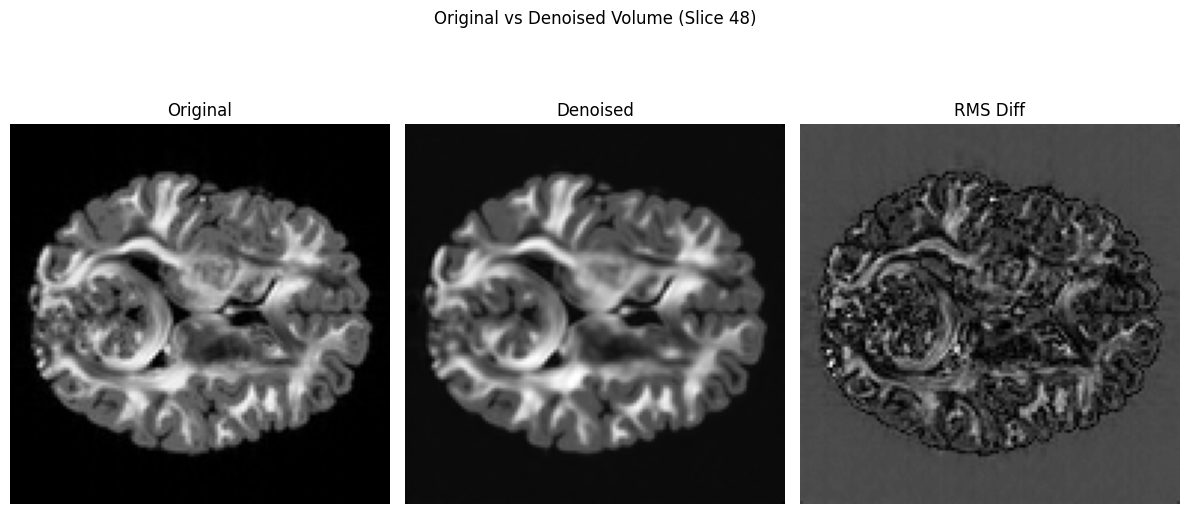

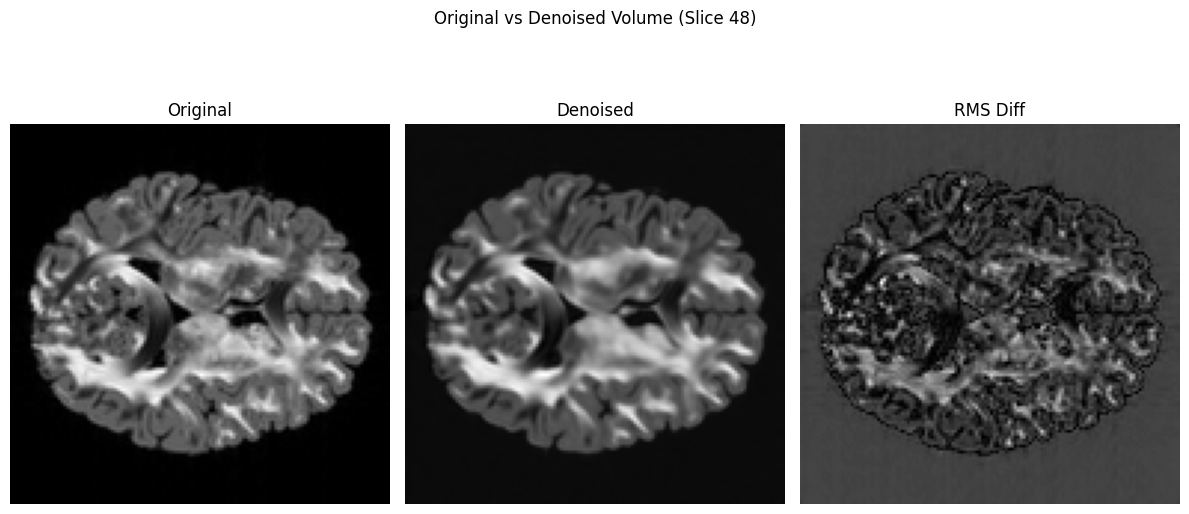

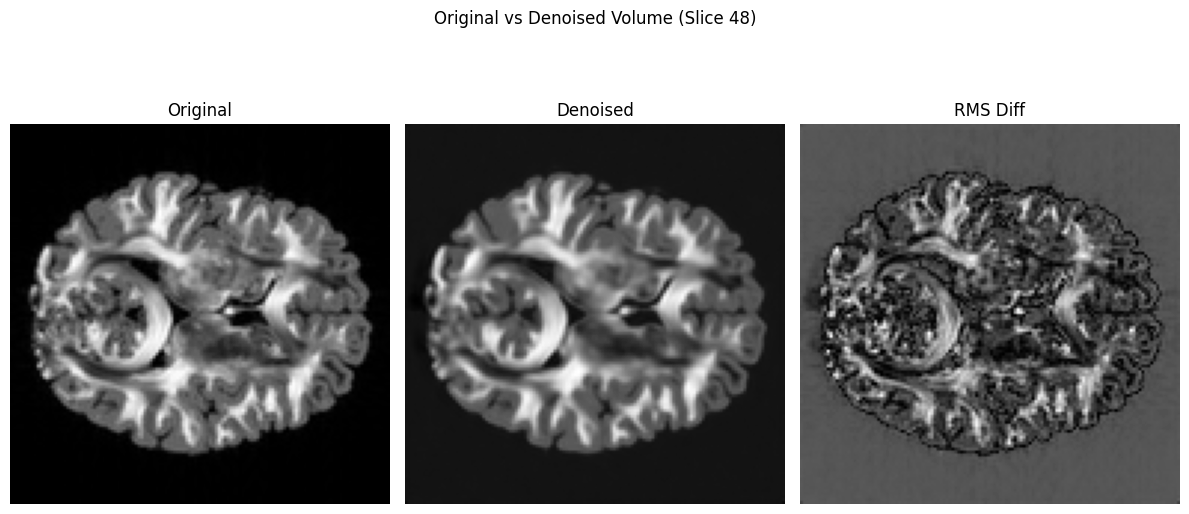

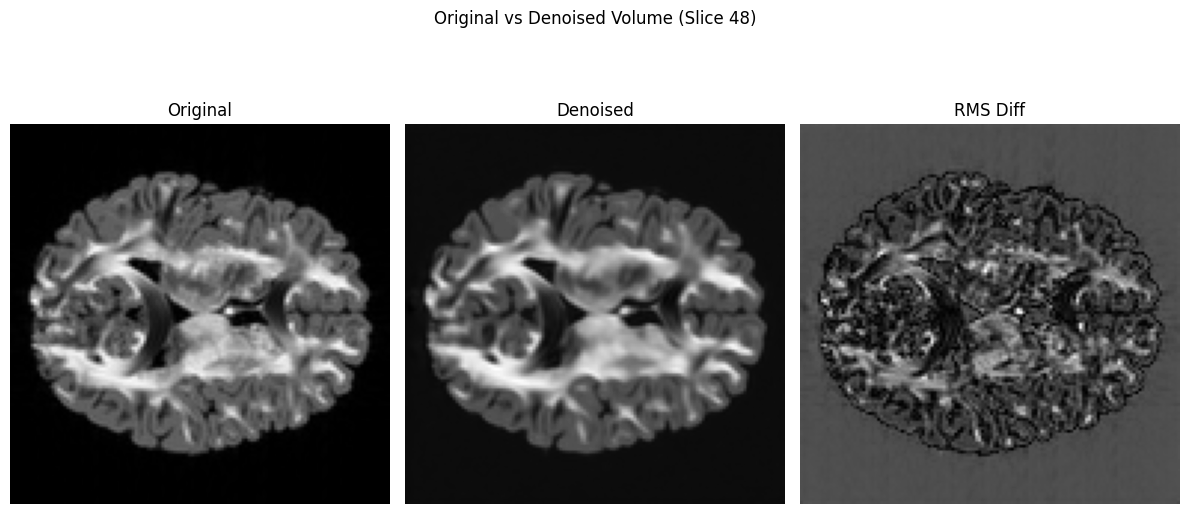

In [10]:
for i in range(10):
    compare_volumes(
                # volumes in b,z,x,y
                np.transpose(original_data[...,6:16], (2, 3, 0, 1)),
                reconstructed_dwis,
                volume_idx=i,
    slice_idx=48,
            )